We begin by importing the necessary modules, as well as the mock dataset we will be using for testing. This consists of mock galaxies that populate a 1.5 Gpc/h on a side cubic box, with periodic boundary conditions.

In [1]:
from densitysplit.pipeline import DensitySplit
from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%config InlineBackend.figure_format='retina'
%matplotlib inline
rc('text', usetex=True)

data_dir = './data'
data_fn = Path(data_dir, 'mock_data.fits')

with fits.open(data_fn) as hdul:
    data = hdul[1].data
data_positions = np.c_[data['X'], data['Y'], data['Z']]



The first step of the density split pipeline consists in estimating the distribution of densities around randomly sampled points. Densities are estimated on a regular grid and smoothed with a tophat filter. We need to specify the size of the grid cells (cellsize), as well as the radius of the smoothing filter (smooth_radius). Since we are working with periodic boundary conditions, we also specify the size of the simulation box (boxsize).

In [8]:
%%time
boxsize = 1500
smooth_radius = 20
cellsize = 10.0

ds = DensitySplit(data_positions=data_positions, boxsize=boxsize)

density = ds.get_density(smooth_radius=smooth_radius, cellsize=cellsize, sampling='randoms')

CPU times: user 1.92 s, sys: 270 ms, total: 2.19 s
Wall time: 2.31 s


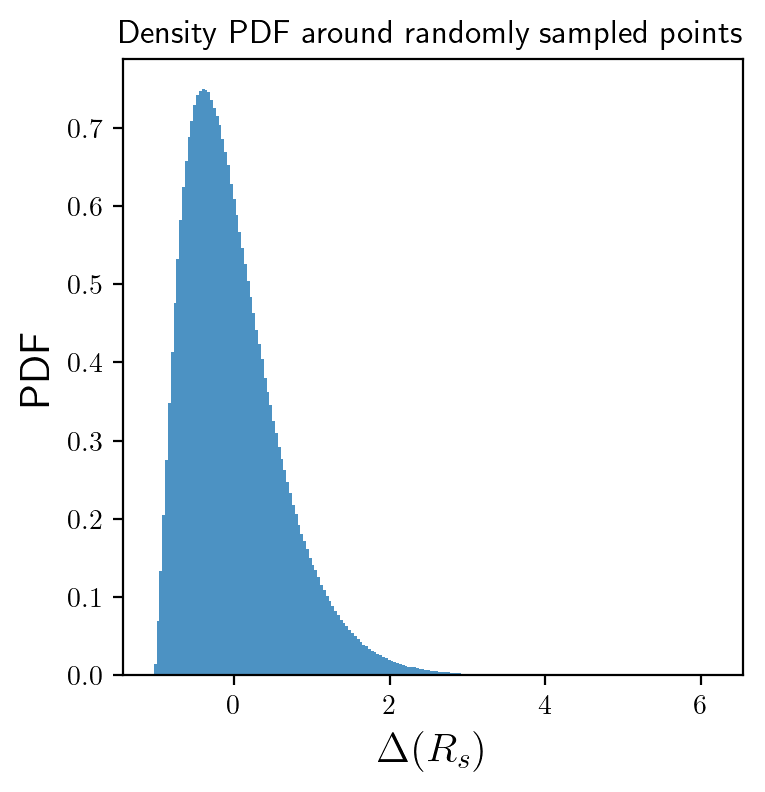

In [9]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(density, bins=200, density=True, alpha=0.8)
ax.set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
ax.set_title('Density PDF around randomly sampled points')
plt.show()

Once we have calculated the density PDF, we proceed to bin the random points by their density. We will split the randoms into 5 density bins or quintiles, which can be specified with the nquantiles argument. The result is a list of 5 arrays, which contain the positions of the random points in each quintile. The quintiles are ordered from lower to higher densities.

In [12]:
quantiles = ds.get_quantiles(nquantiles=5)

print(np.shape(quantiles))
print(quantiles[0][:5])

(5, 1335751, 3)
[[ 275.10676478  456.36336444  787.13464745]
 [ 771.35165762  888.62185329   69.67561908]
 [1423.32830588 1448.44804961 1212.59602217]
 [ 293.97429363   67.84093337  487.99549614]
 [ 535.12999004  421.40176453  814.04412474]]


To visually inspect our results, we plot the quintiles against the positions of galaxies in a thin slice across the z axis of the simulation. We can verify that the first quintile (DS1) positions are preferentially located in regions with very few galaxies, whereas the last quintile (DS5) positions lie in overdense regions of the cosmic web.

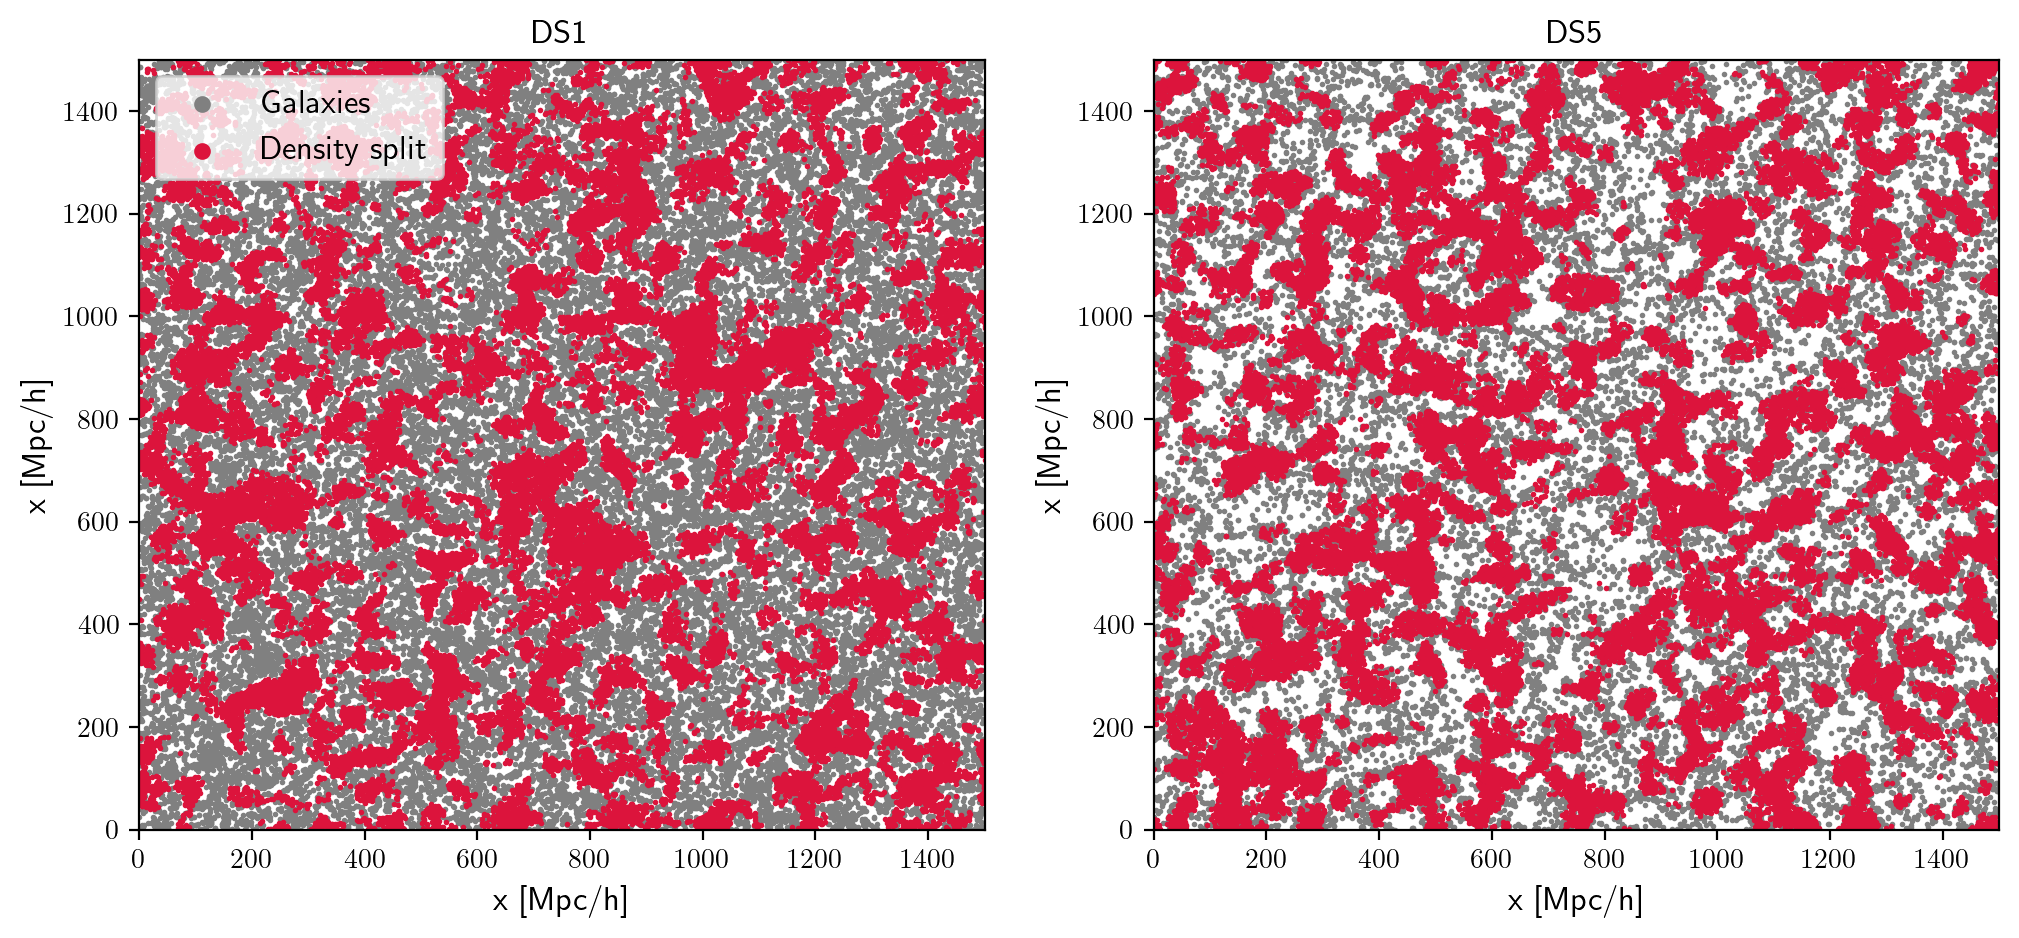

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cut = data_positions[:, 2] < 50
ax[0].scatter(data_positions[cut, 0], data_positions[cut, 1], s=1.0, color='grey', label='Galaxies')
ax[1].scatter(data_positions[cut, 0], data_positions[cut, 1], s=1.0, color='grey', label='Galaxies')

for i, ids in enumerate([0, 4]):
    cut = quantiles[ids][:, 2] < 50

    ax[i].scatter(quantiles[ids][cut, 0], quantiles[ids][cut, 1],
        s=1.0, color='crimson', label='Density split')
    ax[i].set_title(f'DS{ids + 1}', fontsize=12)

    ax[i].set_xlabel('x [Mpc/h]', fontsize=12)
    ax[i].set_ylabel('x [Mpc/h]', fontsize=12)
    ax[i].set_xlim(0, boxsize)
    ax[i].set_ylim(0, boxsize)

ax[0].legend(fontsize=12, markerscale=5, loc='upper left')
plt.show()

We can also work with datasets that do not have periodic boundary conditions, which is the case for observational galaxy surveys. In this case, a random catalogue that describes the window function of the survey needs to be provided.

As a cross-check, we will use the same simulation box as above, but without specifying the boxsize argument (which means there are no periodic boundary conditions). Additionally, we will generate random positions covering the same volume, which will be our random catalogue accounting for the survey window function.

In [15]:
%%time

randoms_positions = np.random.uniform(0, boxsize, (10*len(data_positions), 3))

ds = DensitySplit(data_positions=data_positions, randoms_positions=randoms_positions)

density_wrand = ds.get_density(smooth_radius=smooth_radius, cellsize=cellsize,
    sampling='randoms')

CPU times: user 13.1 s, sys: 1.71 s, total: 14.8 s
Wall time: 15.1 s


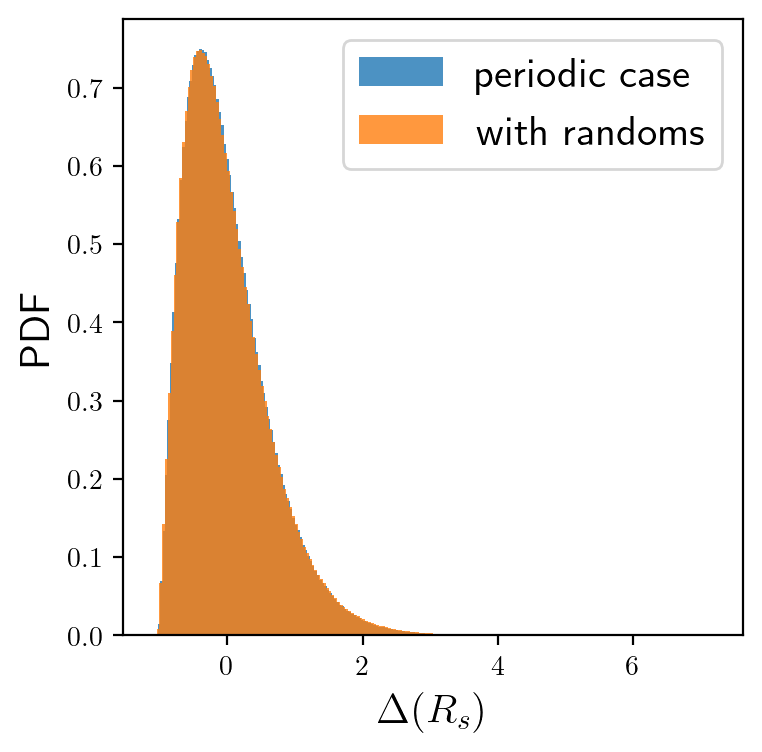

In [18]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(density, bins=200, density=True, alpha=0.8, label='periodic case')
ax.hist(density_wrand, bins=200, density=True, alpha=0.8, label='with randoms')
ax.set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
ax.legend(fontsize=15)
plt.show()

While the original density split pipeline samples the densities around randomly placed positions, we can also sample them around the galaxy positions directly, which can be useful in some studies. To do so, we simply need to change the 'sampling' argument from 'randoms' to 'data'. As there are naturally more galaxies living in crowded regions, the density PDF sampled around the galaxies will be skewed to the right compared to the random sampling case.

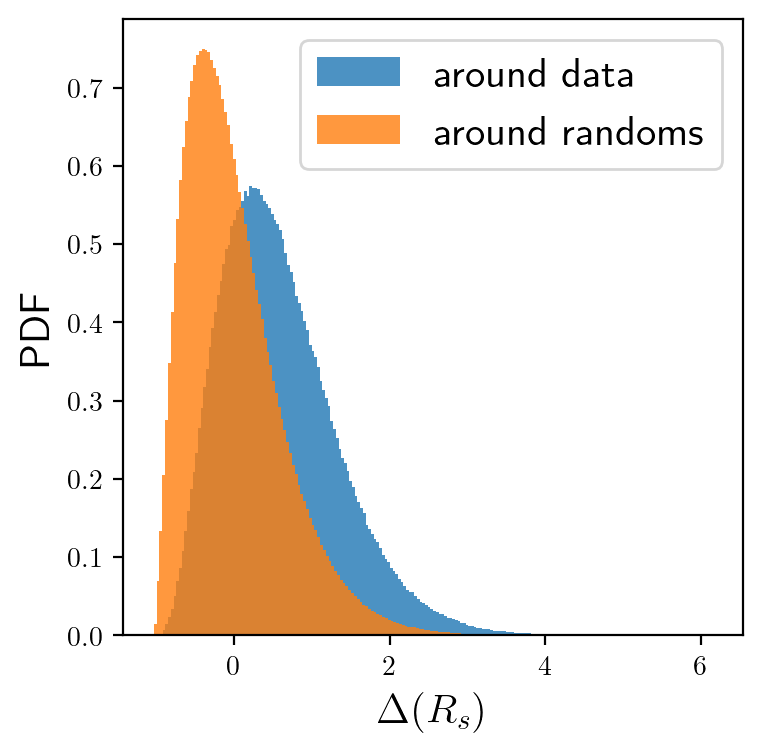

In [19]:
ds = DensitySplit(data_positions=data_positions, boxsize=boxsize)

density_data = ds.get_density(smooth_radius=smooth_radius, cellsize=cellsize, sampling='data')
density_randoms = ds.get_density(smooth_radius=smooth_radius, cellsize=cellsize, sampling='randoms')

fig, ax = plt.subplots(figsize=(4,4))
ax.hist(density_data, bins=200, density=True, alpha=0.8, label='around data')
ax.hist(density_randoms, bins=200, density=True, alpha=0.8, label='around randoms')
ax.set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
ax.legend(fontsize=15)
plt.show()

We can also provide our own array of sampling positions by using the sampling_positions argument.

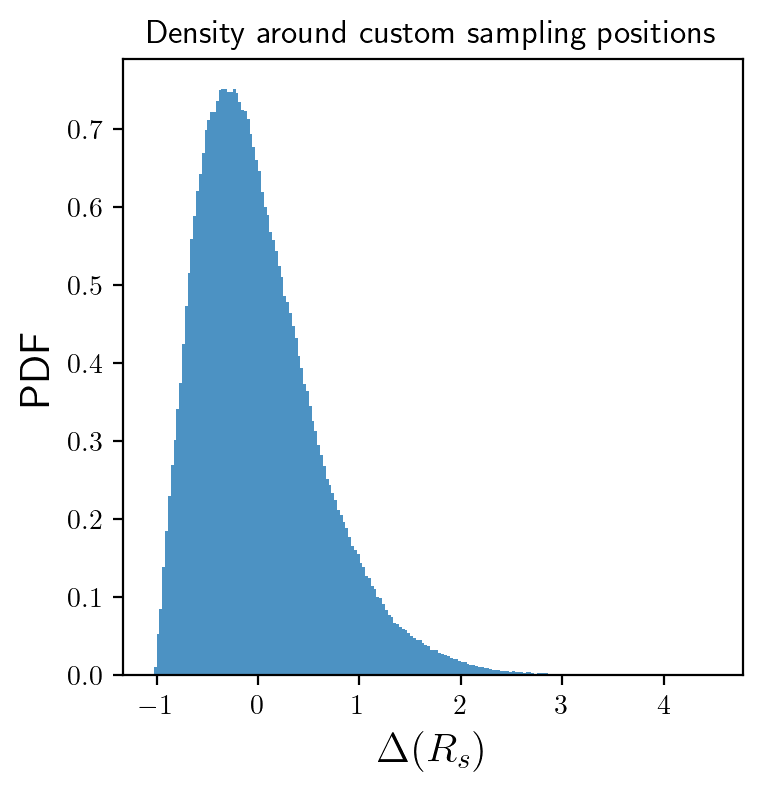

In [26]:
sampling_positions = np.random.uniform(200, 500, (len(data_positions), 3))

ds = DensitySplit(data_positions=data_positions, boxsize=boxsize)

density = ds.get_density(smooth_radius=smooth_radius, cellsize=cellsize, sampling_positions=sampling_positions)

fig, ax = plt.subplots(figsize=(4,4))
ax.hist(density, bins=200, density=True, alpha=0.8)
ax.set_xlabel(r'$\Delta(R_s)$', fontsize=15)
ax.set_ylabel('PDF', fontsize=15)
ax.set_title('Density around custom sampling positions')
plt.show()